In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
sns.set(style="ticks", context="talk")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import optuna
from optuna.samplers import TPESampler

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
# For EDA
import statsmodels.api as sm
from scipy import stats

In [26]:
# Loading data from train, test and submission csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

## Data cleaning and imputation 

In [27]:
# Function to check for duplicates 
def remove_duplicate(data):
    data.drop_duplicates(keep="first", inplace=True)
    return "Checked Duplicates"

In [28]:
remove_duplicate(train)

'Checked Duplicates'

In [29]:
# Define function to Impute missing values with a new dummy variable , this is done to preserve as much information as possible
def impute_nan_create_category(DataFrame,ColName):
     DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),"Unknown",DataFrame[ColName])

In [30]:
# Apply on train 
for Columns in ['Credit_Product']:
    impute_nan_create_category(train,Columns)

In [31]:
# Apply on test 
for Columns in ['Credit_Product']:
    impute_nan_create_category(test,Columns)

In [32]:
# Function to display information about dataframe
data_types = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
def display_data_information(data, data_types):
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_types = data.select_dtypes(include=[ VARIABLE ]).dtypes
    if len(data_types) > 0 :
        print(str(len(data_types))+" "+VARIABLE+" Features\n"+str(data_types)+"\n" )

In [33]:
# Display info about train
display_data_information(train, data_types)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 22.5+ MB




In [34]:
# Display info about test
display_data_information(test, data_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       105312 non-null  object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB




In [35]:
# Dropping the ID column 

train = train.drop('ID', axis=1)
test = test.drop('ID', axis=1)

In [36]:
train.head()

Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  Female   73       RG268          Other           X3       43   
1  Female   30       RG277       Salaried           X1       32   
2  Female   56       RG268  Self_Employed           X3       26   
3    Male   34       RG270       Salaried           X1       19   
4  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

In [37]:
test.head()

Gender  Age Region_Code Occupation Channel_Code  Vintage Credit_Product  \
0    Male   29       RG254      Other           X1       25            Yes   
1    Male   43       RG268      Other           X2       49        Unknown   
2    Male   31       RG270   Salaried           X1       14             No   
3    Male   29       RG272      Other           X1       33             No   
4  Female   29       RG270      Other           X1       19             No   

   Avg_Account_Balance Is_Active  
0               742366        No  
1               925537        No  
2               215949        No  
3               868070        No  
4               657087        No

## EDA Part 

### EDA using logistic regression 


In [38]:
train_eda = train 

In [39]:
X_eda = train_eda.drop('Is_Lead', axis=1)
y_eda = train_eda[['Is_Lead']]
X_eda = pd.get_dummies(X_eda, drop_first=True)

In [40]:
X_train_eda, X_test_eda, y_train_eda, y_test_eda = train_test_split(X_eda, y_eda, test_size=0.25)

### Build the logistic regression model:

In [41]:
logit = sm.Logit(y_train_eda, sm.add_constant(X_train_eda))
lg = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366493
         Iterations 7


### Check the summary of the model 

In [42]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:                Is_Lead   No. Observations:               184293
Model:                          Logit   Df Residuals:                   184245
Method:                           MLE   Df Model:                           47
Date:                Mon, 31 May 2021   Pseudo R-squ.:                  0.3313
Time:                        19:01:57   Log-Likelihood:                -67542.
converged:                       True   LL-Null:                   -1.0101e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.6725      0.100    -36.852      0.000      -3.868      -3.477
Age                          0.0083      0.001     10.640      0.000       0.007       0.

### The pseudo r-square shows that only 33% of the entire variation in the data is explained by the model. It is really not a good model!

### We will calculate the odds ratio from the coefficients using the formula odds ratio=exp(coef). Next we will calculate the probability from the odds ratio using the formula probability = odds / (1+odds) and filter by decending odds ratio 

In [43]:
log_coef = pd.DataFrame(lg.params, columns=['coef'])
log_coef.loc[:, "Odds_ratio"] = np.exp(log_coef.coef)
log_coef['probability'] = log_coef['Odds_ratio']/(1+log_coef['Odds_ratio'])
log_coef['pval']=lg.pvalues
pd.options.display.float_format = '{:.2f}'.format

In [44]:
log_coef = log_coef.sort_values(by="Odds_ratio", ascending=False)
pval_filter = log_coef['pval']<=0.1
log_coef[pval_filter]

coef  Odds_ratio  probability  pval
Credit_Product_Unknown    4.00       54.43         0.98  0.00
Credit_Product_Yes        1.61        5.01         0.83  0.00
Channel_Code_X2           0.94        2.57         0.72  0.00
Channel_Code_X4           0.84        2.31         0.70  0.00
Channel_Code_X3           0.80        2.23         0.69  0.00
Is_Active_Yes             0.35        1.42         0.59  0.00
Region_Code_RG263         0.31        1.36         0.58  0.00
Region_Code_RG269         0.29        1.34         0.57  0.00
Region_Code_RG277         0.26        1.30         0.56  0.00
Region_Code_RG273         0.24        1.27         0.56  0.01
Region_Code_RG279         0.22        1.25         0.56  0.02
Occupation_Salaried       0.21        1.24         0.55  0.00
Region_Code_RG255         0.21        1.23         0.55  0.05
Region_Code_RG284         0.20        1.22         0.55  0.01
Region_Code_RG280         0.19        1.21         0.55  0.02
Region_Code_RG276         0.19        1.20         0.55  0.06
Region_Code_RG268         0.18        1.20         0.55  0.02
Region_Code_RG251         0.17        1.19         0.54  0.05
Region_Code_RG252         0.17        1.19         0.54  0.08
Region_Code_RG257         0.15        1.16         0.54  0.09
Region_Code_RG270         0.15        1.16         0.54  0.09
Region_Code_RG283         0.15        1.16         0.54  0.06
Gender_Male               0.04        1.05         0.51  0.00
Vintage                   0.01        1.01         0.50  0.00
Age                       0.01        1.01         0.50  0.00
Avg_Account_Balance      -0.00        1.00         0.50  0.00
Region_Code_RG267        -0.23        0.80         0.44  0.07
Occupation_Self_Employed -0.69        0.50         0.33  0.00
Occupation_Other         -0.80        0.45         0.31  0.00
const                    -3.67        0.03         0.02  0.00

If we analyze the data, we can see that the customers who have unknown credit product  have a 98% probability of becoming the lead while the ones having yes have 83% probability of becoming a lead.

Similarly, the customers in channel code X2 have odds of 2.59 to become a lead as compared to others , this empasise the importance of credit product. 

## Visual EDA

In [45]:
train['Is_Lead'] = le.fit_transform(train['Is_Lead'])
#train['Is_Active'] = le.fit_transform(train['Is_Lead'])

<AxesSubplot:ylabel='Is_Lead'>

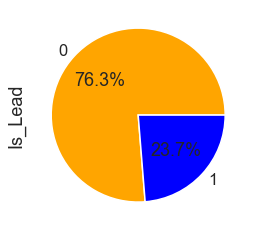

In [46]:
train['Is_Lead'].value_counts().plot.pie(autopct = '%1.1f%%',colors=['Orange','Blue'], figsize = (4,4))

### Data is Imbalanced. Only 23.7% of customers are likely to become lead.

<AxesSubplot:xlabel='Gender', ylabel='count'>

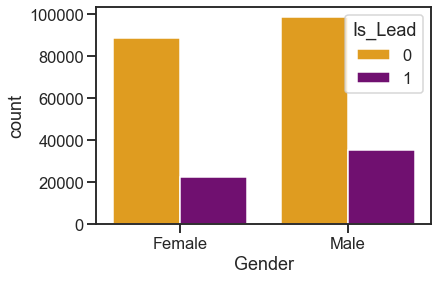

In [47]:
# Check the distribution of target variable with respect to gender
sns.countplot(train['Gender'], hue = train['Is_Lead'],palette=['Orange','Purple'])

### There are more leads in male customers 

<AxesSubplot:xlabel='Age'>

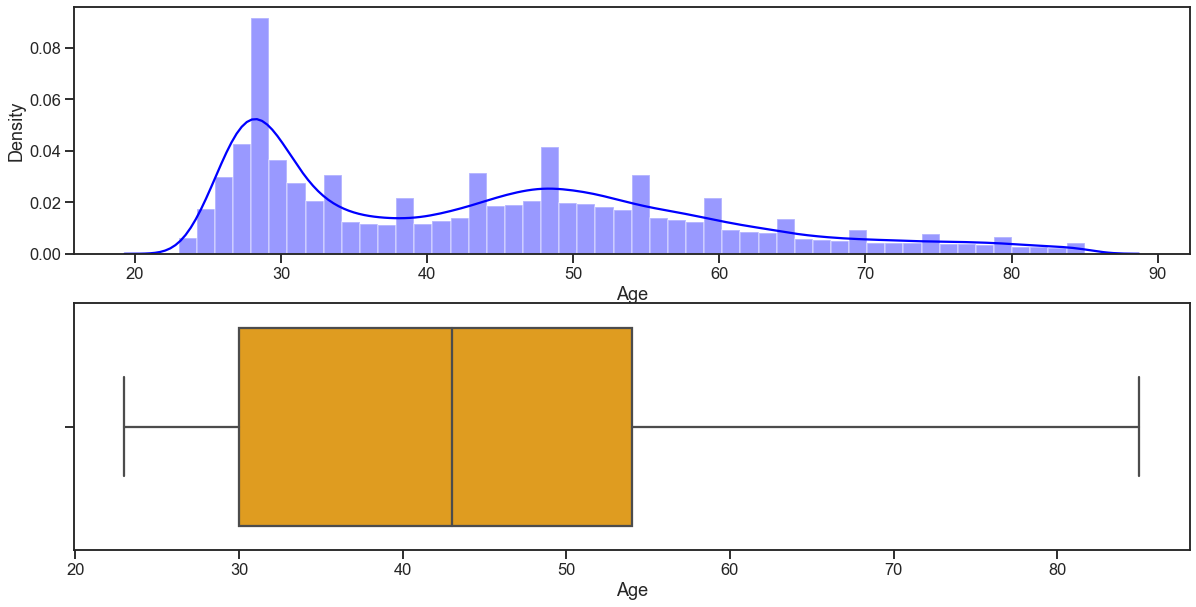

In [48]:
# Check the distribution of Age
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10))
axx = ax.flatten()
#plt.figure(figsize=(30,10))
sns.distplot(train['Age'],ax=axx[0], color='Blue')
sns.boxplot(train['Age'],ax=axx[1],color='Orange')

### Most of the people are in age group of 30-55

In [49]:
# Based on this observation we divide age into bins
age_grp_20_to_30 = train[ train['Age'] <31]
age_grp_31_to_40 = train[ train['Age'].between(31,40)]
age_grp_41_to_50 = train[ train['Age'].between(41,50)]
age_grp_50_to_60 = train[ train['Age'].between(51,60)]
age_grp_old = train[ train['Age'] >60]

age_grp = [age_grp_20_to_30,age_grp_31_to_40,age_grp_41_to_50,age_grp_50_to_60,age_grp_old]
age_grp_name = ['age_grp_20_to_30','age_grp_31_to_40','age_grp_41_to_50','age_grp_50_to_60','age_grp_old']
age_grp_dict = dict(zip(age_grp_name, age_grp))

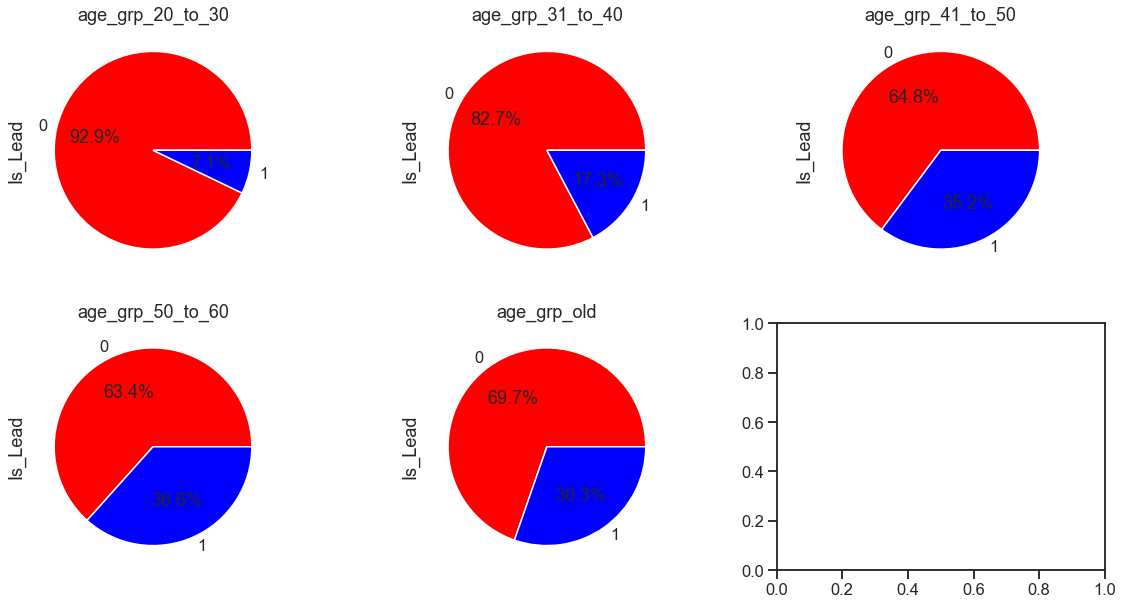

In [50]:
# Check the distribution of target variable with respect to age  
f,ax = plt.subplots(nrows=2, ncols=3, figsize = (20,10))
axx = ax.flatten()
for pos,tup in enumerate(age_grp_dict.items()):
    axx[pos].set_title(tup[0])
    data = tup[1]
    data['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%', ax = axx[pos],colors=['Red','Blue'])

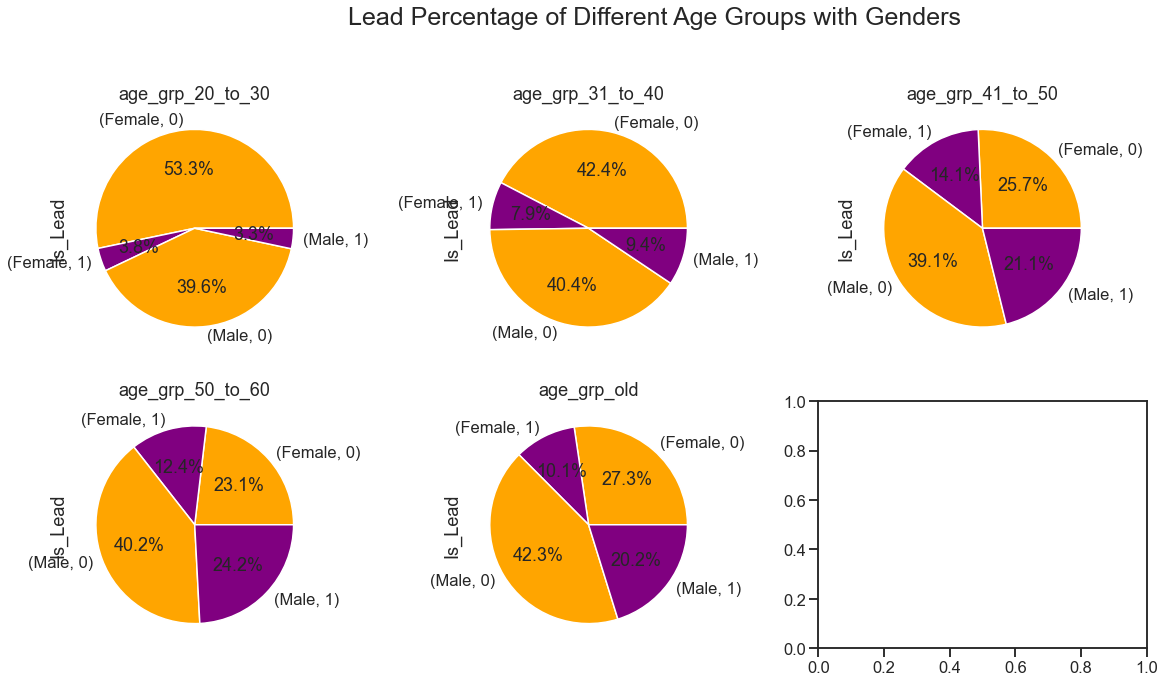

In [51]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize = (20,10))
axx = ax.flatten()
plt.title('Lead Percentage of Different Age Groups with Genders',fontsize=25,x=-0.5,y=2.5)
for pos,tup in enumerate(age_grp_dict.items()):
    axx[pos].set_title(tup[0])
    temp = tup[1]
    temp.groupby('Gender')['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%', ax = axx[pos],colors=['Orange','Purple'])

### Age group 50-60 and 41-50 and age group old , males seem to be the dominant customers 

<AxesSubplot:ylabel='Credit_Product'>

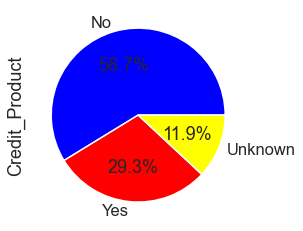

In [52]:
train['Credit_Product'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red', 'Yellow'])

### Distribution of credit product 

<AxesSubplot:title={'center':'Credit_Procuct = Unknown'}, ylabel='Is_Lead'>

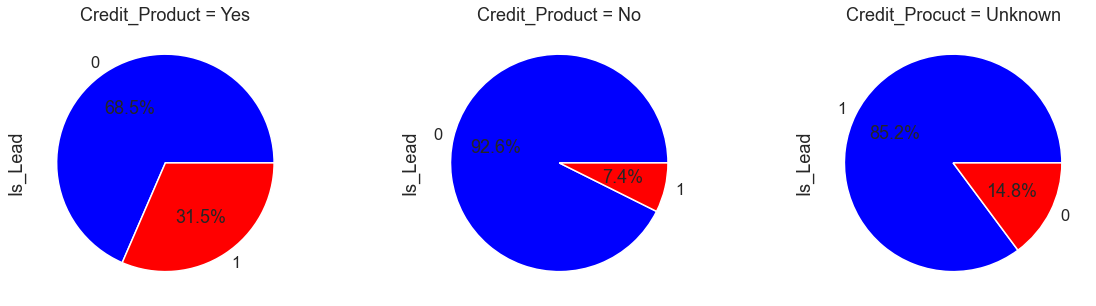

In [53]:
f,ax = plt.subplots(nrows=1,ncols=3,figsize = (20,5))
axx = ax.flatten()
#plt.title('Driving_License wise Response',fontsize=40,x=-0.5,y=2)
axx[0].set_title('Credit_Product = Yes')
axx[1].set_title('Credit_Product = No')
axx[2].set_title('Credit_Procuct = Unknown')
train[ train['Credit_Product'] == 'Yes']['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[0])
train[ train['Credit_Product'] == 'No']['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[1])
train[ train['Credit_Product'] == 'Unknown']['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[2])

###  This provides a revealing information that the missing credit product column contains 85.2% lead , dropping it would have been a mistake  

<AxesSubplot:title={'center':'Is_Active = No'}, ylabel='Is_Lead'>

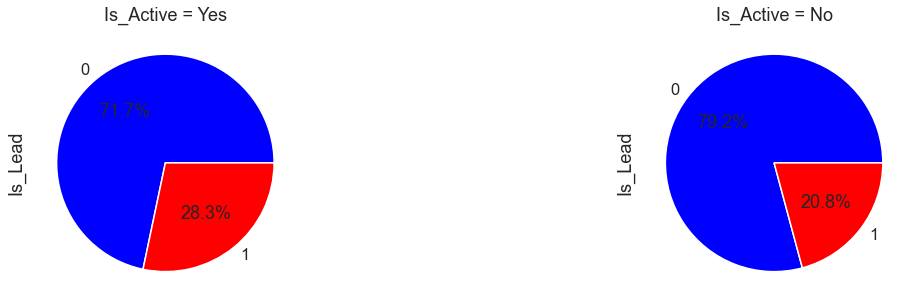

In [54]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize = (20,5))
axx = ax.flatten()
#plt.title('Driving_License wise Response',fontsize=40,x=-0.5,y=2)
axx[0].set_title('Is_Active = Yes')
axx[1].set_title('Is_Active = No')
train[ train['Is_Active'] == 'Yes']['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[0])
train[ train['Is_Active'] == 'No']['Is_Lead'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[1])

### Is_active is present in rough;y same manner in trget distribution 


<AxesSubplot:title={'center':'Region Wise Response Count'}, xlabel='Region_Code', ylabel='count'>

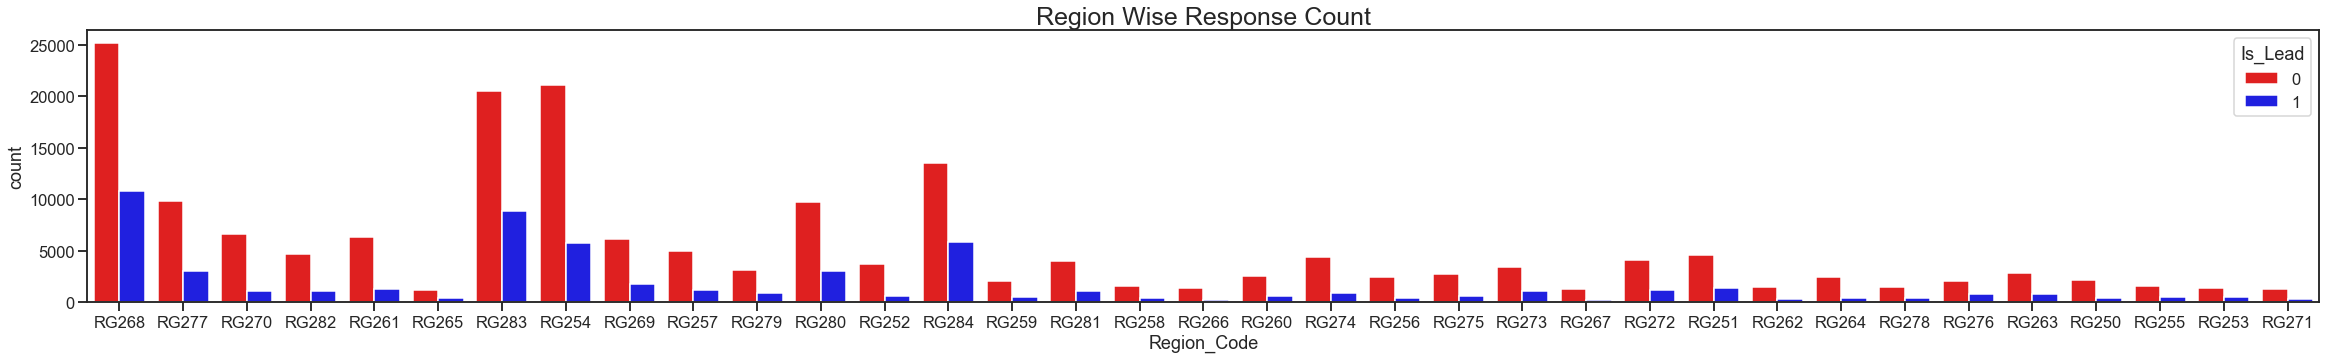

In [55]:
plt.figure(figsize = (40,5))
plt.title('Region Wise Response Count',fontsize=25)
sns.countplot(train['Region_Code'], hue = train['Is_Lead'],palette=['Red','Blue'])

### Region code 283 and 254, 284, 268 have highest number of customers 

In [56]:
u_region = train['Region_Code'].unique()
region_perc = {}
for i in u_region:
    total_region = train[ train['Region_Code'] == i].shape[0]
    buy_region = train[ (train['Region_Code'] == i) & train['Is_Lead'] == 1].shape[0]
    region_perc[i] = (buy_region/total_region)*100

region_perc = sorted(region_perc.items(), key=lambda x: x[1], reverse=True)
region_perc = list(zip(*region_perc))

region = np.array(region_perc[0])
region_perc = np.array(region_perc[1])
region = pd.DataFrame(region)
region_perc = pd.DataFrame(region_perc)

region_res_perc = pd.concat((region,region_perc), axis=1)
region_res_perc.columns = ['Region_Code', 'Buy_Percentage']

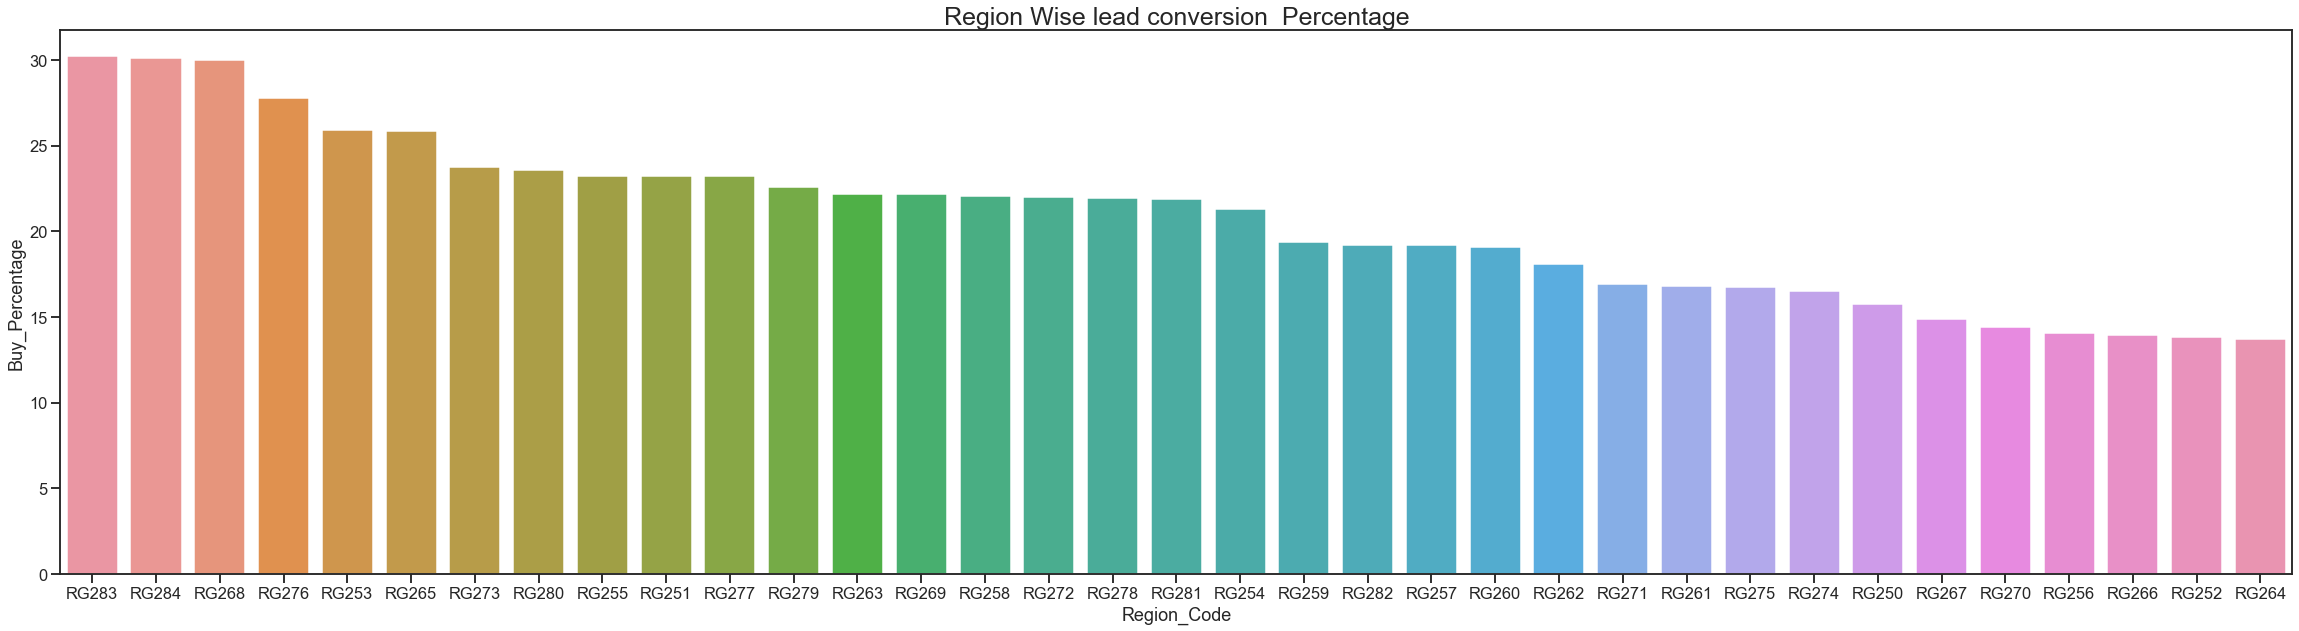

In [57]:
plt.figure(figsize=(40,10))
plt.title('Region Wise lead conversion  Percentage',fontsize=25)
ax = sns.barplot(x = region_res_perc['Region_Code'], y = region_res_perc['Buy_Percentage'])

### Which regions have highest lead  percentage

<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

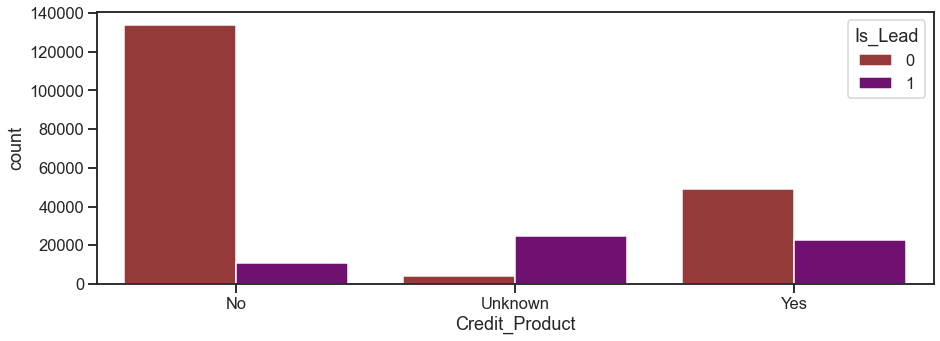

In [58]:
plt.figure(figsize=(15,5))
sns.countplot(train['Credit_Product'],hue=train['Is_Lead'],palette=['Brown','Purple'])

### Importance of Credit_product variable is visible and the missing values contain a lot of leads 

<AxesSubplot:ylabel='Occupation'>

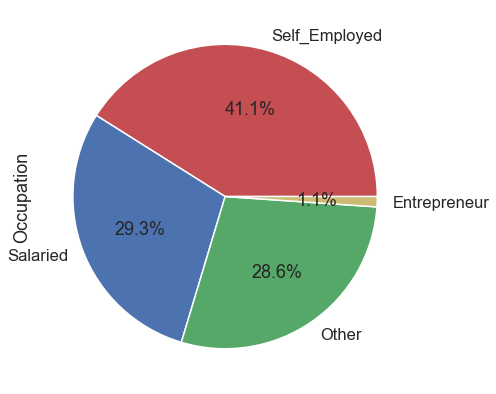

In [59]:
plt.figure(figsize=(7,7))
train['Occupation'].value_counts().plot.pie(autopct='%1.1f%%', colors = ['r', 'b', 'g', 'y'])

### Distribution of Occupation 

<AxesSubplot:xlabel='Occupation', ylabel='count'>

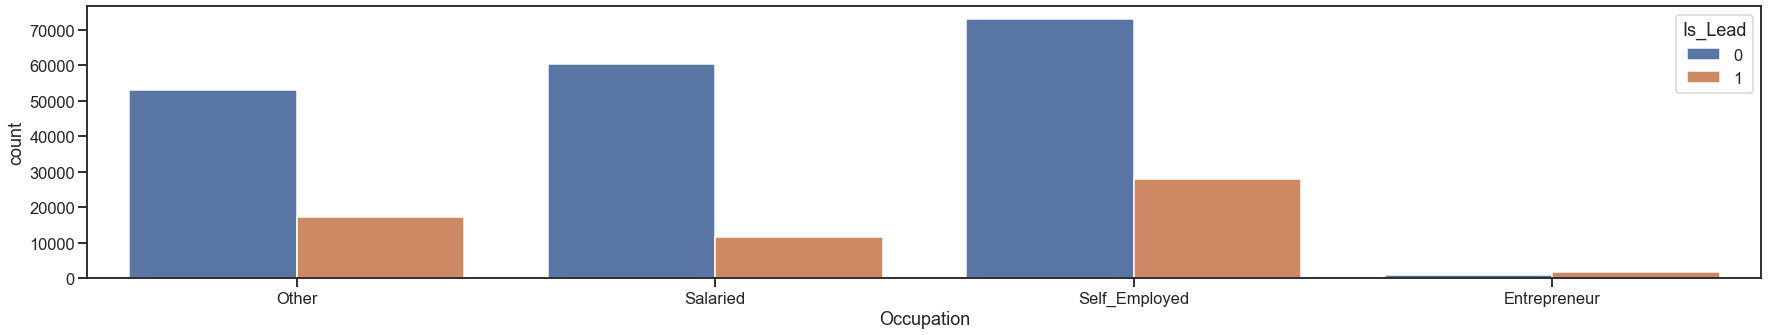

In [60]:
plt.figure(figsize = (30,5))
sns.countplot(train['Occupation'], hue = train['Is_Lead'])

### Self Employed people have the most number of leads 

In [61]:
ls = train['Occupation'].unique()

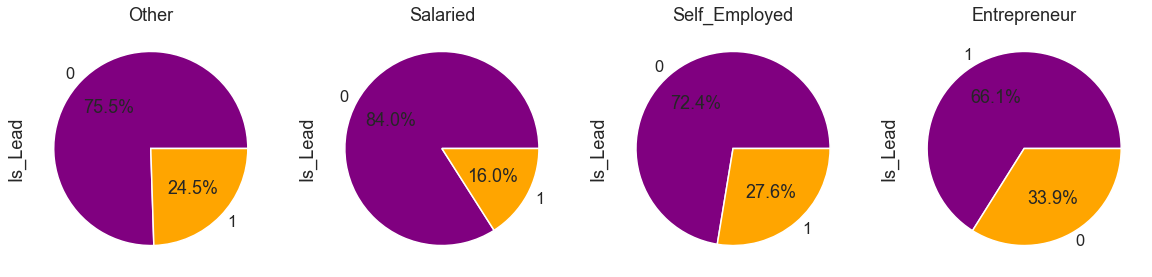

In [62]:
f,ax = plt.subplots(nrows=1, ncols=4,figsize = (20,7))
axx = ax.flatten()
for pos,val in enumerate(ls):
    axx[pos].set_title(str(val))
    train[ train['Occupation'] == val]['Is_Lead'].value_counts().plot.pie(autopct = '%1.1f%%',ax = axx[pos], colors=['Purple', 'Orange'])

### Entrepreneures have most leads whereas salaried the least 

<AxesSubplot:xlabel='Is_Active', ylabel='count'>

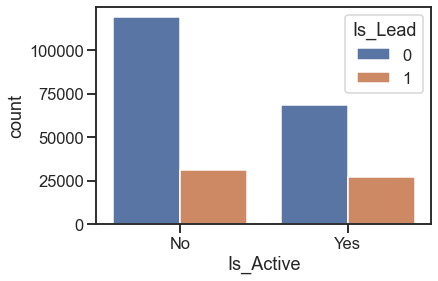

In [63]:
sns.countplot(train['Is_Active'], hue = train['Is_Lead'])

### Number of leads is equally distributed in both active and not active 

<AxesSubplot:xlabel='Avg_Account_Balance'>

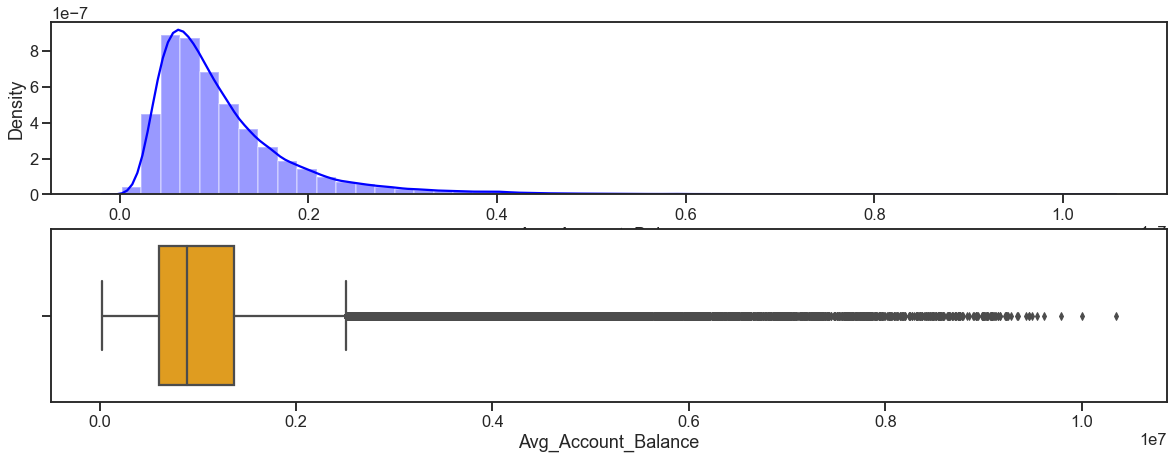

In [64]:
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,7))
axx = ax.flatten()
#plt.figure(figsize=(30,10))
sns.distplot(train['Avg_Account_Balance'],ax=axx[0], color='Blue')
sns.boxplot(train['Avg_Account_Balance'],ax=axx[1],color='Orange')

### Average account balance is highly skwed 

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

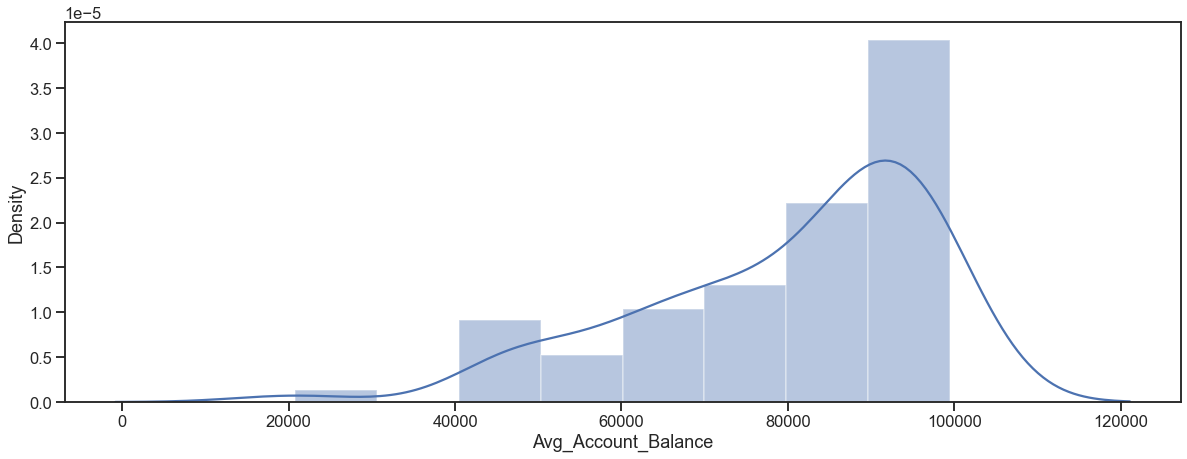

In [65]:
plt.figure(figsize=(20,7))
sns.distplot(train[ train['Avg_Account_Balance'] < 100000]['Avg_Account_Balance'])#.plot.hist(bins = 500, frequency=(0,10000))

<AxesSubplot:>

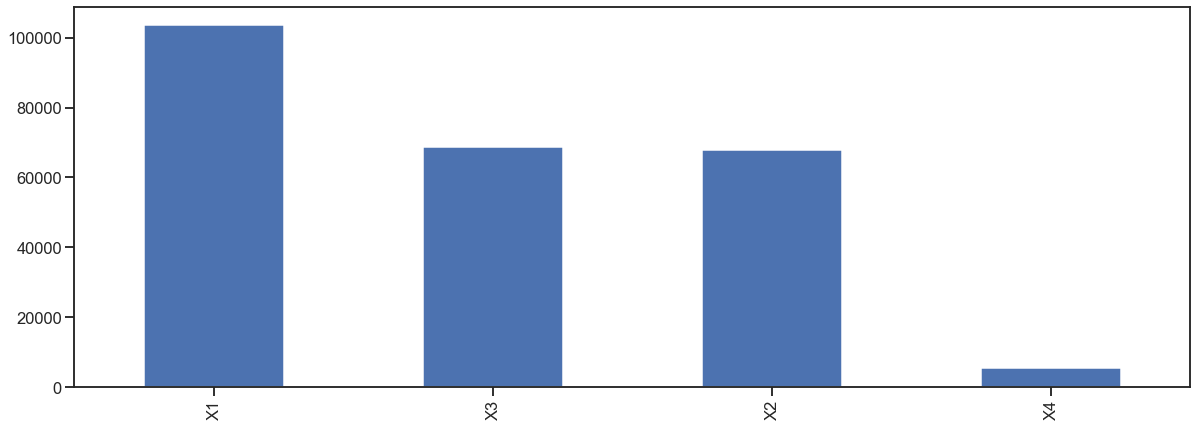

In [66]:
plt.figure(figsize=(20,7))
train['Channel_Code'].value_counts().plot.bar()

### Channel code X4 has least values 

<AxesSubplot:xlabel='Vintage'>

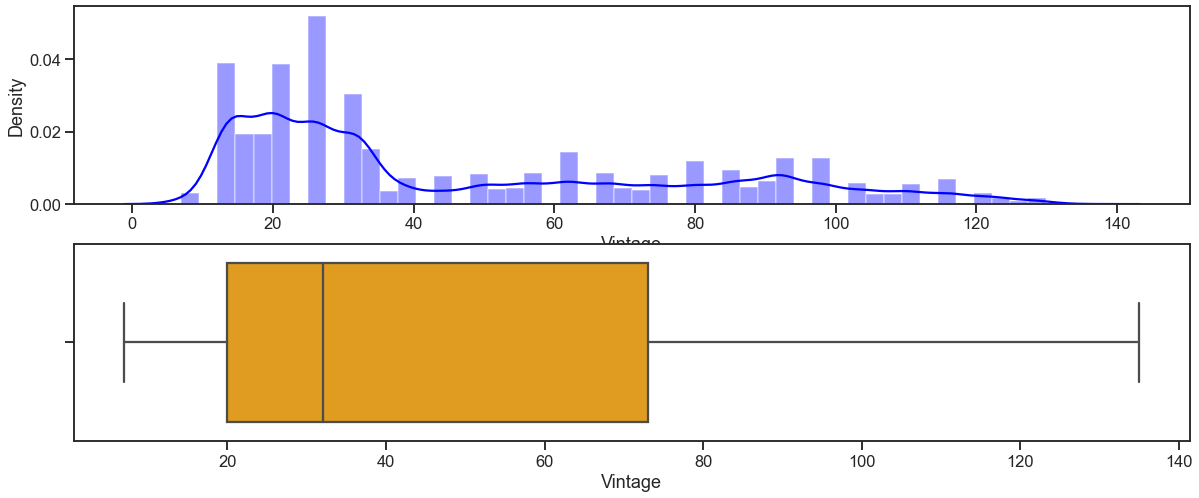

In [67]:
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,8))
axx = ax.flatten()
sns.distplot(train['Vintage'],ax=axx[0], color='Blue')
sns.boxplot(train['Vintage'],ax=axx[1],color='Orange')

In [68]:
# To combine and plot xcorr
train_copy =  train 
test_copy = test 
train_copy['is_train'] = 1
test_copy['is_train'] = 0
test_copy['Is_Lead'] = None

In [69]:
data = pd.concat((train_copy,test_copy))
#data.set_index('ID',inplace=True)
data.shape

(351037, 11)

<AxesSubplot:xlabel='Age'>

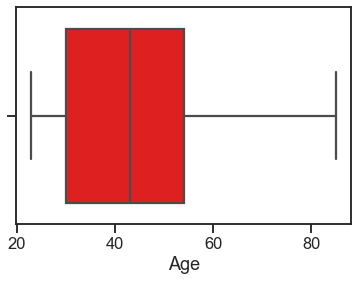

In [70]:
sns.boxplot('Age', data=data, orient='v', color='Red')

<AxesSubplot:xlabel='Avg_Account_Balance'>

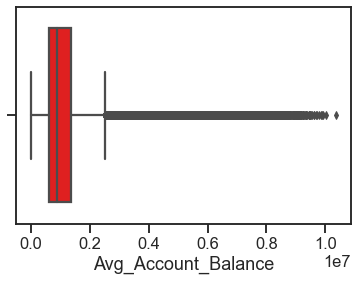

In [71]:
sns.boxplot('Avg_Account_Balance', data=data,orient='v', color='red')

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

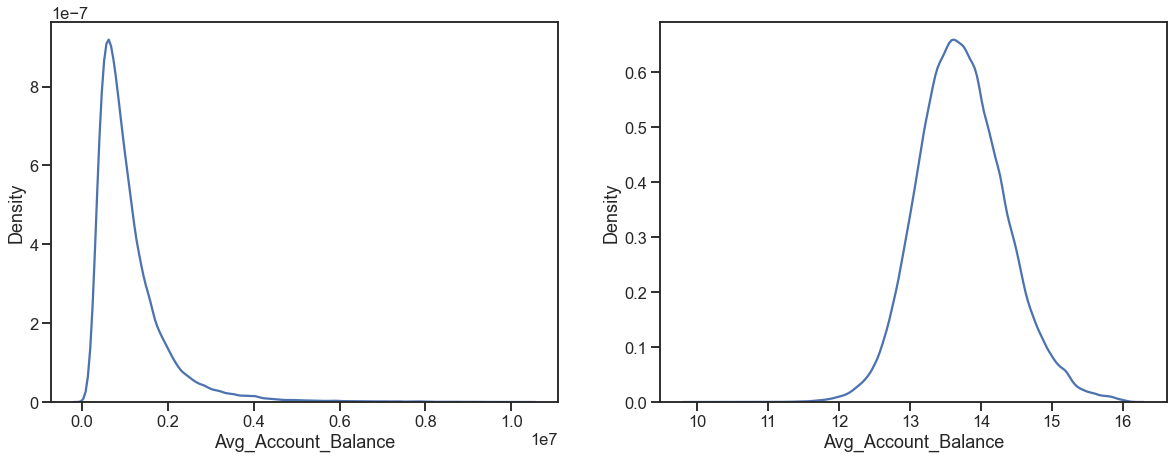

In [72]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize = (20,7))
axx = ax.flatten()
sns.kdeplot(data['Avg_Account_Balance'], legend=False,ax = axx[0])
sns.kdeplot(np.log(data['Avg_Account_Balance']), legend=False,ax = axx[1]) # after using log transformation

In [73]:
corr_check = data.copy()

col_ls = ['Gender', 'Occupation', 'Is_Active', 'Region_Code', 'Channel_Code', 'Credit_Product']

for col in col_ls:
    corr_check[col] = le.fit_transform(corr_check[col])

<AxesSubplot:>

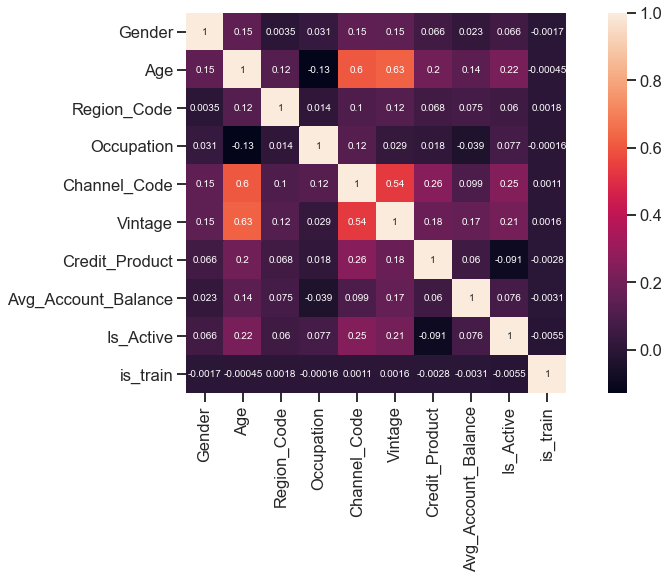

In [74]:
plt.figure(figsize=(15,7))
sns.heatmap(corr_check.corr(), annot=True, square=True,annot_kws={'size': 10})

### Channel code and vintage are positively related 

## Convert categorical columns , assign labels 

In [75]:
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train['Occupation']=train['Occupation'].replace({'Other':0,'Salaried':1,'Self_Employed':2, 'Entrepreneur':3})
train['Occupation']=train['Occupation'].astype(int)
train['Region_Code']=train['Region_Code'].replace({'RG268':0,'RG277':1,'RG270':2,'RG282':3,'RG261':4, 'RG265':5, 'RG283':6, 'RG254':7,
                                                              'RG269':8, 'RG257':9, 'RG279':10, 'RG280':11, 'RG252':12, 'RG284':13, 'RG259':14,
                                                              'RG281':15, 'RG258':16, 'RG266':17, 'RG260':18, 'RG274':19, 'RG256':20, 'RG275':21,
                                                              'RG273':22, 'RG267':23, 'RG272':24, 'RG251':25, 'RG262':26, 'RG264':27, 'RG278':28,
                                                              'RG276':29, 'RG263':30, 'RG250':31, 'RG255':32, 'RG253':33, 'RG271':34})
train['Channel_Code']=train['Channel_Code'].replace({'X3':2,'X1':0,'X2':1,'X4':3})
train['Credit_Product']=train['Credit_Product'].replace({'No':0,'Yes':1, 'Unknown':2})
train['Is_Active']=train['Is_Active'].replace({'No':0,'Yes':1})

In [76]:
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
test['Occupation']=test['Occupation'].replace({'Other':0,'Salaried':1,'Self_Employed':2, 'Entrepreneur':3})
test['Occupation']=test['Occupation'].astype(int)
test['Region_Code']=test['Region_Code'].replace({'RG268':0,'RG277':1,'RG270':2,'RG282':3,'RG261':4, 'RG265':5, 'RG283':6, 'RG254':7,
                                                              'RG269':8, 'RG257':9, 'RG279':10, 'RG280':11, 'RG252':12, 'RG284':13, 'RG259':14,
                                                              'RG281':15, 'RG258':16, 'RG266':17, 'RG260':18, 'RG274':19, 'RG256':20, 'RG275':21,
                                                              'RG273':22, 'RG267':23, 'RG272':24, 'RG251':25, 'RG262':26, 'RG264':27, 'RG278':28,
                                                              'RG276':29, 'RG263':30, 'RG250':31, 'RG255':32, 'RG253':33, 'RG271':34})
test['Channel_Code']=test['Channel_Code'].replace({'X3':2,'X1':0,'X2':1,'X4':3})
test['Credit_Product']=test['Credit_Product'].replace({'No':0,'Yes':1, 'Unknown':2})
test['Is_Active']=test['Is_Active'].replace({'No':0,'Yes':1})

In [77]:
test.head()

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0       1   29            7           0             0       25   
1       1   43            0           0             1       49   
2       1   31            2           1             0       14   
3       1   29           24           0             0       33   
4       0   29            2           0             0       19   

   Credit_Product  Avg_Account_Balance  Is_Active  is_train Is_Lead  
0               1               742366          0         0    None  
1               2               925537          0         0    None  
2               0               215949          0         0    None  
3               0               868070          0         0    None  
4               0               657087          0         0    None

In [78]:
### Create list of categorical features 

In [79]:
features=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']
cat_col=['Gender','Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active' ]

### Create test train data

In [80]:
X = train.drop('Is_Lead', axis=1)
y = train[['Is_Lead']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=150303,stratify=y,shuffle=True)

# Model Building, Training and Optimization 

### Initialize catboost classifier 

In [82]:
catb = CatBoostClassifier()
catb= catb.fit(X_train, y_train,cat_features=cat_col,eval_set=(X_test, y_test),early_stopping_rounds=30,verbose=100)
y_pred = catb.predict(X_test)
proba = catb.predict_proba(X_test)[:, 1]
print('CatBoost Base Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('CatBoost Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

Learning rate set to 0.114945
0:	learn: 0.6028619	test: 0.6026259	best: 0.6026259 (0)	total: 702ms	remaining: 11m 41s
100:	learn: 0.3432853	test: 0.3438030	best: 0.3438030 (100)	total: 43.6s	remaining: 6m 28s
200:	learn: 0.3403123	test: 0.3433307	best: 0.3433302 (193)	total: 1m 32s	remaining: 6m 8s
300:	learn: 0.3384483	test: 0.3431277	best: 0.3431019 (281)	total: 2m 22s	remaining: 5m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3431018896
bestIteration = 281

Shrink model to first 282 iterations.
CatBoost Base Accuracy : 0.8615054043495247
CatBoost Base ROC_AUC_SCORE: 0.8742214465349564


### Initialize base LGBM classifier

In [83]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

In [84]:
# Base model metrics 
print('LGBM Base Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('LGBM Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

LGBM Base Accuracy : 0.8614402917046491
LGBM Base ROC_AUC_SCORE: 0.8742083381221291


### Tune Model 

In [85]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=0
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,proba)
    return score

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)
proba = lgb.predict_proba(X_test)[:,1]
print('Optimized LightGBM roc_auc_score', roc_auc_score(y_test, proba))

[I 2021-05-31 19:05:15,643] A new study created in memory with name: no-name-f6775403-9e22-4430-8fa8-83b2efa5057d
[I 2021-05-31 19:05:58,731] Trial 0 finished with value: 0.8275461074618633 and parameters: {'max_depth': 17, 'n_estimators': 358, 'learning_rate': 0.6027634157953062, 'num_leaves': 2725, 'min_child_samples': 86, 'reg_alpha': 7, 'reg_lambda': 5}. Best is trial 0 with value: 0.8275461074618633.
[I 2021-05-31 19:07:18,568] Trial 1 finished with value: 0.8304127171550418 and parameters: {'max_depth': 27, 'n_estimators': 482, 'learning_rate': 0.38344158048162585, 'num_leaves': 3959, 'min_child_samples': 107, 'reg_alpha': 6, 'reg_lambda': 10}. Best is trial 1 with value: 0.8304127171550418.
[I 2021-05-31 19:07:20,029] Trial 2 finished with value: 0.8637071667856396 and parameters: {'max_depth': 4, 'n_estimators': 44, 'learning_rate': 0.020218495418485975, 'num_leaves': 4164, 'min_child_samples': 157, 'reg_alpha': 9, 'reg_lambda': 10}. Best is trial 2 with value: 0.86370716678563

In [86]:
lgb

LGBMClassifier(learning_rate=0.06646648000751526, max_depth=4,
               min_child_samples=181, n_estimators=345, num_leaves=916,
               random_state=0, reg_alpha=7, reg_lambda=4)

### Fit Tuned model 

In [87]:
LGBM = lgb
LGBM.fit(X, y)
y_pred = LGBM.predict(X_test)
proba = LGBM.predict_proba(X_test)[:,1]

In [88]:
print('LGBM Tuned Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('LGBM Tuned ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

LGBM Tuned Accuracy : 0.8623681468941269
LGBM Tuned ROC_AUC_SCORE: 0.8773578060122436


In [89]:
test = test.drop(['Is_Lead'], axis=1)

### Stacking the models 

In [90]:
LGBM_proba = LGBM.predict_proba(test)[:, 1] # Class 1 probability of LGBM model
cat_proba = catb.predict_proba(test)[:, 1] # Class 1 probability of CatBoost model

In [91]:
submit_proba = ((LGBM_proba * 0.45) + (cat_proba * 0.55))/2
sample_sub['Is_Lead'] = submit_proba

## Prepare submission 

In [92]:
##sample_sub.to_csv('sixth_submission.csv', index=False) 